# Analyzing Catalogs Subject to Selection Effects

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [32]:
import arviz as az
import aesara.tensor as at
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.special as sp
import scipy.stats as ss
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('husl')

## Inhomogeneous Poisson Likelihood

...some boardwork deriving the IPL:
$$
p\left( x \mid \theta \right) = \exp\left( - N\left( \theta \right) \right) \prod_{i=1}^{N_\mathrm{obs}} \frac{\mathrm{d}N}{\mathrm{d} x_i}\left( \theta \right)
$$
.  Eventually talking about Schechter luminosity function:
$$
\frac{\mathrm{d} N}{\mathrm{d} \log L \mathrm{d} V} = L \frac{\mathrm{d} N}{\mathrm{d} L \mathrm{d} V} = n \left( \frac{L}{L_*} \right)^\alpha \exp\left( -\frac{L}{L_*} \right).
$$
Statisticians call this the gamma distribution with shape parameter $\alpha$ and scale parameter $L_*$.

Note: $n$ is the density per log luminosity per volume of objects with luminosity $L = L_*$.  In a volume $V$, there will be 
$$
N = \int \mathrm{d} \log L \, \mathrm{d} V \, \frac{\mathrm{d} N}{\mathrm{d} \log L \mathrm{d} V} = \Gamma(\alpha) n V
$$
objects from this distribution.  We will draw a sample from this luminosity function 

Text(2.6944444444444517, 0.5, '$V \\mathrm{d}N/\\mathrm{d} \\log L \\mathrm{d} V$')

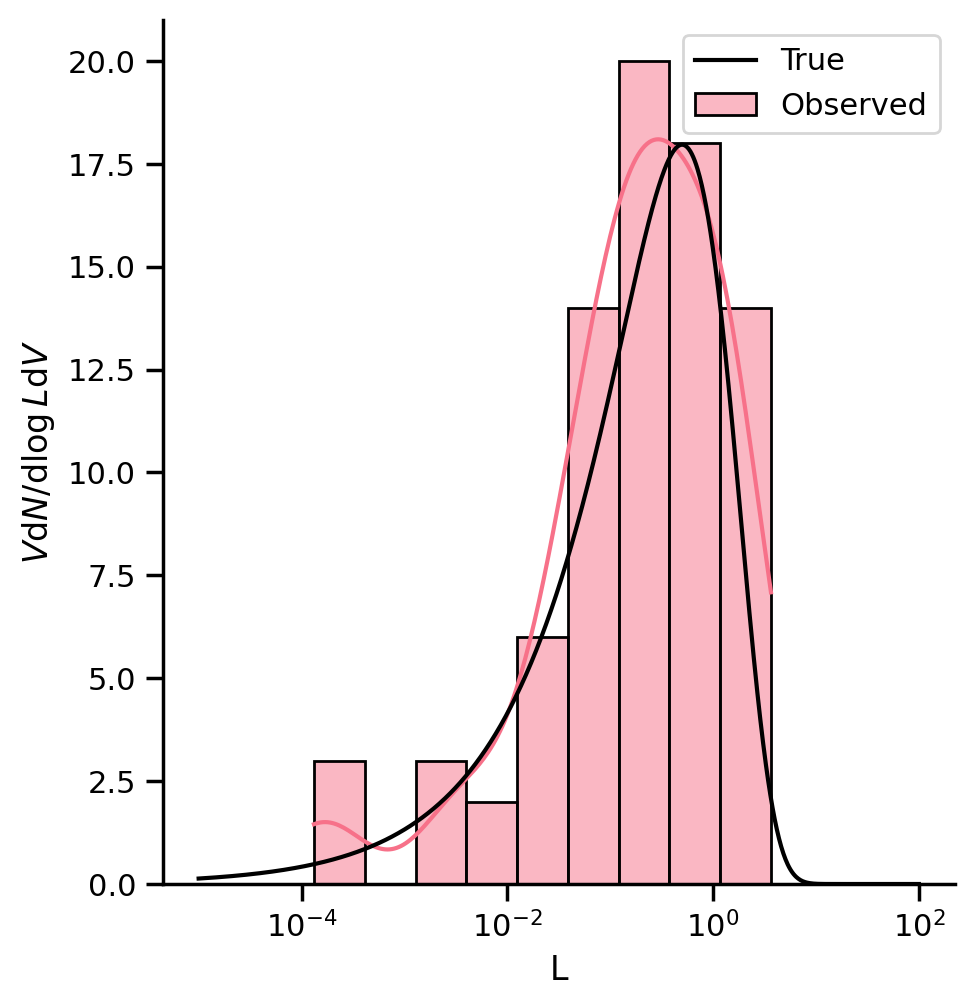

In [31]:
n_true = 10.0
alpha_true = 0.5
LStar_true = 1.0
V = 4/3*np.pi # Sphere of radius 1

N_true = np.random.poisson(n_true*sp.gamma(alpha_true)*V)
L = np.random.gamma(shape=alpha_true, scale=LStar_true, size=N_true)

sns.displot(L, log_scale=True, label='Observed', kde=True)
xs = np.logspace(-5, 2, 1000)
plt.plot(xs, V*n_true*sp.gamma(alpha_true)*ss.gamma(alpha_true, scale=LStar_true).pdf(xs)*xs, color='k', label='True')
plt.legend()
plt.xlabel(r"L")
plt.ylabel(r"$V \mathrm{d}N/\mathrm{d} \log L \mathrm{d} V$")

And now we build a pymc model to fit the data:

In [35]:
def make_Lf_model(L, V):
    with pm.Model() as model:
        n = pm.LogNormal('n', mu=np.log(10), sigma=1)
        alpha = pm.HalfNormal('alpha', sigma=1)
        LStar = pm.LogNormal('LStar', mu=np.log(1), sigma=1)

        _ = pm.Potential('likelihood', at.sum(at.log(n) + (alpha-1)*at.log(L) - alpha*at.log(LStar) - L/LStar) - n*V*at.gamma(alpha))
    return model


In [37]:
with make_Lf_model(L, V) as Lf_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [n, alpha, LStar]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


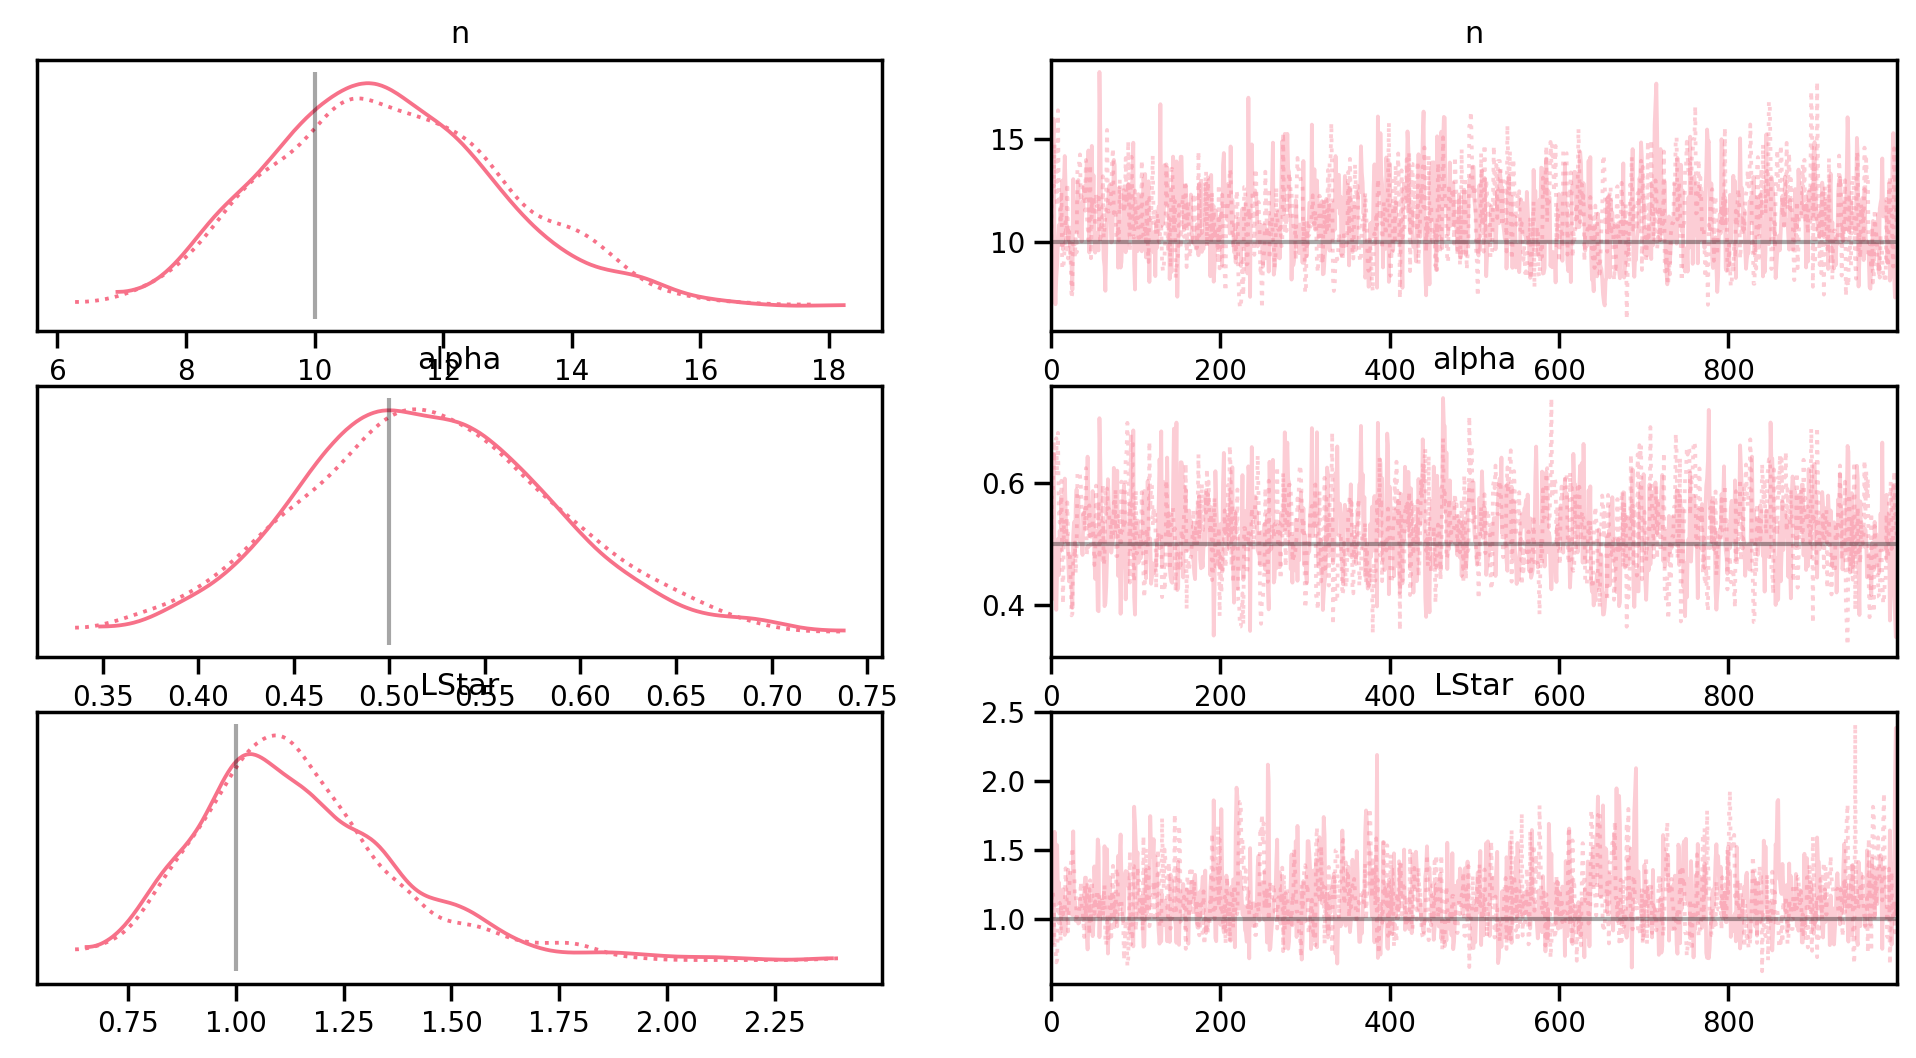

In [39]:
with Lf_model:
    az.plot_trace(trace, lines=[('n', {}, n_true), ('alpha', {}, alpha_true), ('LStar', {}, LStar_true)])